In [ ]:
!pwd

In [1]:
import pandas as pd
import os
import shutil
import cv2
from multiprocessing import Pool
import time
import process_images_448_448
import process_images_128_128
import gc
import matplotlib.pyplot as plt
import random
import tarfile

In [ ]:
# !ls /cygdrive/c/Apps/jupyter/jupyterWorkspace

In [ ]:
# !cd train

In [ ]:
# !bash download-dataset.sh test 19

In [ ]:
for i in range(1,20):
    if i<10:
        download_url = "https://s3.amazonaws.com/google-landmark/test/images_00"+str(i)+".tar"
        save_url = "test/images_00"+str(i)+".tar"
    else:
        download_url = "https://s3.amazonaws.com/google-landmark/test/images_0"+str(i)+".tar"
        save_url = "test/images_0"+str(i)+".tar"
    print(download_url)
    !wget {download_url} -O {save_url}

In [ ]:
# import tarfile
# train_extract_location = "train"
# for i in range(0,1):
#   if i<10:
#     train_tar_location = "/cygdrive/e/google_landmark_detection_dataset/train/images_00"+str(i)+".tar"
#   elif (i>9 and i<100):
#     train_tar_location = "/cygdrive/e/google_landmark_detection_dataset/train/images_0"+str(i)+".tar"
#   else:
#     train_tar_location = "/cygdrive/e/google_landmark_detection_dataset/train/images_"+str(i)+".tar"
#   print(train_tar_location)
#   my_tar = tarfile.open(train_tar_location)
#   my_tar.extractall(train_extract_location)
#   my_tar.close()

In [6]:
import tarfile
test_extract_location = "test"
for i in range(1,20):
    if i<10:
        test_tar_location = "test/images_00"+str(i)+".tar"
    else:
        test_tar_location = "test/images_0"+str(i)+".tar"
    print(test_tar_location)
    my_tar = tarfile.open(test_tar_location)
    my_tar.extractall(test_extract_location)
    my_tar.close()

test/images_001.tar
test/images_002.tar
test/images_003.tar
test/images_004.tar
test/images_005.tar
test/images_006.tar
test/images_007.tar
test/images_008.tar
test/images_009.tar
test/images_010.tar
test/images_011.tar
test/images_012.tar
test/images_013.tar
test/images_014.tar
test/images_015.tar
test/images_016.tar
test/images_017.tar
test/images_018.tar
test/images_019.tar


In [2]:
train_file_csv_df = pd.read_csv("train.csv")

In [20]:
test_file_csv_df = pd.read_csv("test.csv")
test_file_solution_csv_df = pd.read_csv("recognition_solution_v2_1.csv")

In [4]:
landmarks_greater_than_5_df = train_file_csv_df.landmark_id.value_counts().reset_index(name="count").query('count>5')
print("Sample of record in the train_file_csv_df dataframe : \n" + str(train_file_csv_df.head(1)))
print("Total number of images in the training set : " + str(train_file_csv_df['url'].count()))
print("Total number of unique landmark_ids in the training dataset : " + str(train_file_csv_df.landmark_id.value_counts()
                                                                                 .reset_index(name="count")["index"].count()))
print("Total number of landmarks with greater than 5 images in the dataset : " + str(landmarks_greater_than_5_df["index"].count()))

Sample of record in the train_file_csv_df dataframe : 
                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
Total number of images in the training set : 4132914
Total number of unique landmark_ids in the training dataset : 203094
Total number of landmarks with greater than 5 images in the dataset : 125731


In [5]:
filtered_train_greater_than_5_df = train_file_csv_df[train_file_csv_df.landmark_id.isin(landmarks_greater_than_5_df['index'])]
print("Total number of images for landmarks with image count of greater than 5 in the training set after filtering  : " + str(filtered_train_greater_than_5_df["id"].count()))
print(filtered_train_greater_than_5_df.head(1))
print(filtered_train_greater_than_5_df.iloc[1]['url'])

Total number of images for landmarks with image count of greater than 5 in the training set after filtering  : 3920020
                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
http://upload.wikimedia.org/wikipedia/commons/6/63/Ecosse200996-1.jpg


In [6]:
imageIds_landmarkIds_dict = filtered_train_greater_than_5_df.set_index('id')['landmark_id'].to_dict()
len(imageIds_landmarkIds_dict)

3920020

In [7]:
imageIds_landmarkIds_dict

{'6e158a47eb2ca3f6': 142820,
 '202cd79556f30760': 104169,
 '3ad87684c99c06e1': 37914,
 'e7f70e9c61e66af3': 102140,
 '4072182eddd0100e': 2474,
 '5554f8798114ed04': 149463,
 '6f31b874d1a4d489': 6888,
 '16d8aa057cdd01b9': 25719,
 '3968e37e503f3109': 122849,
 '8df019949b8db328': 81049,
 'ccf070a2da242d56': 138982,
 '88f3f71c2b71a6f9': 198623,
 'b7ece1aad4506b6c': 41286,
 '1d3231ccc4b8581e': 187670,
 '0851a257e5e872ef': 189446,
 '4570e7fc14ebfbba': 109163,
 '9ca3f578a1621b94': 51103,
 '8e947d76a7541bbc': 135850,
 '2e5ca26d9b436887': 117635,
 'ec1a06b33bc85437': 73107,
 '053d1409647dfba2': 74821,
 'f1556e1eeeba213f': 36639,
 '3cdc355c6232712f': 12877,
 '873ccbc51840638c': 63367,
 '6d41b12f2fba07da': 47417,
 '495f56a28e4b0b13': 19402,
 '5095627580bf7b14': 17465,
 'ab23192cbd17cc1c': 100587,
 '350c1d3f31682da7': 157667,
 '2e2e9c38045e331f': 89919,
 '6084519de4caed00': 86294,
 'eafd5f84fc92ff5d': 40847,
 '6e901d6b9d4da278': 101718,
 '0e03e45d48d3400f': 155483,
 'ebe3deda076fc5e9': 43200,
 'cc6b

In [18]:
print(test_file_csv_df.count())
print(test_file_csv_df.head())

id    117577
dtype: int64
                 id
0  00016575233bc956
1  0001aadbcd8cb923
2  0002c06b2440a5f9
3  0002eb1ee5a5a6b2
4  000594dad986513e


In [21]:
print(test_file_solution_csv_df.count())
print(test_file_solution_csv_df.head())

id           117577
landmarks      1972
Usage        117577
dtype: int64
                 id landmarks    Usage
0  e324e0f3e6d9e504       NaN  Private
1  d9e17c5f3e0c47b3       NaN  Private
2  1a748a755ed67512       NaN   Public
3  537bf9bdfccdafea       NaN  Private
4  13f4c974274ee08b       NaN  Private


In [ ]:
# This is a one time task. We take the raw images in appropriate directories and save them to training folder after resizing
# to appropriate labeled folders (tmp/train/<labeled folder names>). Then we delete the original folders to save space.

# dir_name_list = ["train/0","train/1","train/2","train/3","train/4","train/5","train/6","train/7","train/8","train/9","train/a","train/b","train/c","train/d","train/e","train/f"]
# for dir_name in dir_name_list:
#     get_list_start_time = time.time()
#     def get_list_of_Files(dir_name):
#         # create a list of file and sub directories 
#         # names in the given directory 
#         listOfFile = os.listdir(dir_name)
#         allFiles = list()
#         # Iterate over all the entries
#         for entry in listOfFile:
#             # Create full path
#             fullPath = os.path.join(dir_name, entry)
#             # If entry is a directory then get the list of files in this directory 
#             if os.path.isdir(fullPath):
#                 allFiles = allFiles + get_list_of_Files(fullPath)
#             else:
#                 allFiles.append(fullPath)             
#         return allFiles

#     list_of_images = get_list_of_Files(dir_name)
#     print("\nTime to get list of files from current directory : ", (time.time() - get_list_start_time))
#     print(list_of_images[:5])
#     print(len(list_of_images))
#     gc.collect()

#     process_image_start_time = time.time()
#     if __name__ == '__main__':
#         p=Pool(8)
#         print("\n", p.map(process_images_448_448.process_save_images, [[list_of_images, imageIds_landmarkIds_dict]]))
#     print("Time to process images in the current directory : ", (time.time() - process_image_start_time))
#     gc.collect()

#     delete_directory_start_time = time.time()
#     path_to_delete = list_of_images[0].split("\\")[0]
#     print("\n", path_to_delete)
#     shutil.rmtree(path_to_delete)
#     print("\nTime to delete images in the current directory : ", (time.time() - delete_directory_start_time))
#     del list_of_images
#     gc.collect()


In [ ]:
# This is a one time task. We take the raw images in appropriate directories and save them to test folder after resizing
# to appropriate labeled folders (tmp/test/<labeled folder names>).

dir_name_list = ["datasets/test/0","datasets/test/1","datasets/test/2","datasets/test/3","datasets/test/4","datasets/test/5","datasets/test/6","datasets/test/7","datasets/test/8","datasets/test/9","datasets/test/a","datasets/test/b","datasets/test/c","datasets/test/d","datasets/test/e","datasets/test/f"]
for dir_name in dir_name_list:
    get_list_start_time = time.time()
    def get_list_of_Files(dir_name):
        # create a list of file and sub directories 
        # names in the given directory 
        listOfFile = os.listdir(dir_name)
        allFiles = list()
        # Iterate over all the entries
        for entry in listOfFile:
            # Create full path
            fullPath = os.path.join(dir_name, entry)
            # If entry is a directory then get the list of files in this directory 
            if os.path.isdir(fullPath):
                allFiles = allFiles + get_list_of_Files(fullPath)
            else:
                allFiles.append(fullPath)             
        return allFiles

    list_of_images = get_list_of_Files(dir_name)
    print("\nTime to get list of files from current directory : ", (time.time() - get_list_start_time))
    print(list_of_images[:5])
    print(len(list_of_images))
    gc.collect()

    process_image_start_time = time.time()
    if __name__ == '__main__':
        p=Pool(8)
        print("\n", p.map(process_images_128_128.process_save_images, [[list_of_images, imageIds_landmarkIds_dict]]))
    print("Time to process images in the current directory : ", (time.time() - process_image_start_time))
    gc.collect()

    delete_directory_start_time = time.time()
    path_to_delete = list_of_images[0].split("\\")[0]
    print("\n", path_to_delete)
    shutil.rmtree(path_to_delete)
    print("\nTime to delete images in the current directory : ", (time.time() - delete_directory_start_time))
    del list_of_images
    gc.collect()


In [ ]:
# plt.hist(y.landmark_id, bins=100)

In [8]:
landmarkIds_counts_df = pd.DataFrame(filtered_train_greater_than_5_df.landmark_id.value_counts())
landmarkIds_counts_df = landmarkIds_counts_df.rename(columns={'landmark_id':'counts'})
landmarkIds_counts_df.reset_index(level=0, inplace=True)
landmarkIds_counts_df = landmarkIds_counts_df.rename(columns={'index':'landmark_id'})
landmarkIds_counts_df['landmark_id'] = landmarkIds_counts_df['landmark_id'].astype('str')
print(len(landmarkIds_counts_df))
landmarkIds_counts_dict = landmarkIds_counts_df.set_index('landmark_id')['counts'].to_dict()

125731


In [9]:
landmarkIds_counts_df[:2]

,landmark_id,counts
0,138982,10247
1,62798,4333


(array([8937., 2995., 1335.,  601.,  362.,  218.,  123.,  102.,   81.,
          46.]),
 array([ 58., 104., 150., 196., 242., 288., 334., 380., 426., 472., 518.]),
 <a list of 10 Patch objects>)

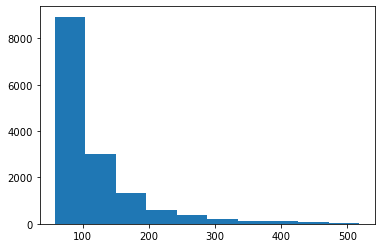

In [15]:
plt.hist(landmarkIds_counts_df.counts[200:15000])
# plt.bar(df.landmark_id,df.counts)

In [25]:
# Now, filter out images where each landmark has only 500 or less images to prevent overfitting on larger set of landmark_ids.
total_landmarks_less_than_100_count = landmarkIds_counts_df[landmarkIds_counts_df.counts<=100].count()
total_landmarks_less_than_100_count

landmark_id    119329
counts         119329
dtype: int64

In [26]:
total_landmarks_less_than_10_count = landmarkIds_counts_df[landmarkIds_counts_df.counts<10]
total_landmarks_less_than_10_count.count()

landmark_id    32991
counts         32991
dtype: int64

In [27]:
# total number of images where landmarks have less than 10 images
total_images_less_than_10 = 0
for item in total_landmarks_less_than_10_count.counts: 
    total_images_less_than_10 +=item
total_images_less_than_10

241819

In [17]:
greater_100 = landmarkIds_counts_df[landmarkIds_counts_df.counts>100]
greater_100.count()

landmark_id    6402
counts         6402
dtype: int64

In [ ]:
# Number of extra images over 100 for the landmarks where landmark has more than 100 images
total_images_greater_than100 = 0
for item in greater_100.counts:
    diff = item-100
    total_images_greater_than100 +=diff
total_images_greater_than100

In [ ]:
greater_than_10 = landmarkIds_counts_df[landmarkIds_counts_df.counts>=10]
greater_than_10.count()

In [ ]:
total_number_of_images_100orless = 0
for item in greater_than_10.counts:
    if item>100:
        total_number_of_images_100orless += 100
    else:
        total_number_of_images_100orless += item
print(total_number_of_images_100orless)
    

In [ ]:
# resize to 128 X 128 

In [ ]:
for k, v in landmarkIds_counts_dict.items():
    print(k,v)
    break

In [ ]:
# # This is a one time task as well. 
# # Resized the images to 128x128 or 256x256 and only inlcuded 100 images per landmark id
# print(greater_than_10[:2])
# dir_name ='tmp/train'

# get_list_start_time = time.time()
# # count = 0

# # image_scale_percent = 30
# # w_and_h = int(448*image_scale_percent/100)

# for landmark in greater_than_10.landmark_id:
#     list_of_files = list()
#     directory = dir_name + '/' + landmark
#     list_of_images = os.listdir(directory)
#     if (landmarkIds_counts_dict[landmark]>100):
#         list_of_images = random.sample(list_of_images,100)
#     for image_file in list_of_images:
#         fullpath_image = os.path.join(directory,image_file)
#         list_of_files.append(fullpath_image)
# #     count += len(list_of_files)
#     process_images_128_128.process_save_images(list_of_files,landmark)
#     del list_of_files
#     del list_of_images
#     gc.collect()
# #     print(len(list_of_files))
# #     print(list_of_files[:2])

# print("\nTime to process all the files : ", (time.time() - get_list_start_time))


In [ ]:
!ls

In [ ]:
# # this is to get list of files in all the landmarks in set_128 directory
# # This process was taking too long. going to try to do it folder by folder.
# get_list_start_time = time.time()
# def get_list_of_files(dir_name):
#     # create a list of file and sub directories 
#     # names in the given directory 
#     listOfFile = os.listdir(dir_name)
#     allFiles = list()
#     # Iterate over all the entries
#     for entry in listOfFile:
#         # Create full path
#         fullPath = os.path.join(dir_name, entry)
#         # If entry is a directory then get the list of files in this directory 
#         if os.path.isdir(fullPath):
#             allFiles = allFiles + get_list_of_files(fullPath)
#         else:
#             allFiles.append(fullPath)             
#     return allFiles

# list_of_images = get_list_of_files('set_128')
# print(list_of_images[:5])
# print("\nTime to get list of files from current directory : ", (time.time() - get_list_start_time))

In [ ]:
# from __future__ import print_function
# import pickle
# import os.path
# from googleapiclient.discovery import build
# from google_auth_oauthlib.flow import InstalledAppFlow
# from google.auth.transport.requests import Request
# from googleapiclient.discovery import MediaFileUpload

# # If modifying these scopes, delete the file token.pickle.
# SCOPES = ['https://www.googleapis.com/auth/drive']
# CLIENT_SECRET_FILE = 'client_secret.json'
# APPLICATION_NAME = 'landmark-detection'

# def get_credentials():
#     creds = None
#     # The file token.pickle stores the user's access and refresh tokens, and is
#     # created automatically when the authorization flow completes for the first
#     # time.
#     if os.path.exists('token.pickle'):
#         with open('token.pickle', 'rb') as token:
#             creds = pickle.load(token)
#     # If there are no (valid) credentials available, let the user log in.
#     if not creds or not creds.valid:
#         if creds and creds.expired and creds.refresh_token:
#             creds.refresh(Request())
#         else:
#             flow = InstalledAppFlow.from_client_secrets_file(
#                 CLIENT_SECRET_FILE, SCOPES)
#             creds = flow.run_local_server(port=0)
#         # Save the credentials for the next run
#         with open('token.pickle', 'wb') as token:
#             pickle.dump(creds, token)
#     return creds
    
# def get_files_list():
#     """Shows basic usage of the Drive v3 API.
#     Prints the names and ids of the first 10 files the user has access to.
#     """
#     creds = get_credentials()

#     service = build('drive', 'v3', credentials=creds)

#     # Call the Drive v3 API
#     results = service.files().list(
#         pageSize=10, fields="nextPageToken, files(id, name)").execute()
#     items = results.get('files', [])

#     if not items:
#         print('No files found.')
#     else:
#         print('Files:')
#         for item in items:
#             print(u'{0} ({1})'.format(item['name'], item['id']))

# def upload_files(list_of_files):
#     creds = get_credentials()

#     service = build('drive', 'v3', credentials=creds)

#     # Call the Drive v3 API
#     for file in list_of_files:
#         filepath = 'datasets/landmark_detection/' + file
#         file_metadata = {'name': filepath}
#         folder_id = filepath.split('/')
#         media = MediaFileUpload(file, mimetype='image/jpeg', resumable=True)
#         file = service.files().create(body=file_metadata,
#                                     media_body=media,
#                                     fields='id').execute()
    
# get_files_list()

In [ ]:
# # Took ~300 secs to upload 100 images. This wont't work.
# dir_name ='set_128/train'

# get_list_start_time = time.time()

# for landmark in greater_than_10.landmark_id[:1]:
#     list_of_files = list()
#     directory = dir_name + '/' + landmark
#     list_of_images = os.listdir(directory)
#     for image_file in list_of_images:
#         fullpath_image =  directory + '/' + image_file#os.path.join(directory,image_file)
#         list_of_files.append(fullpath_image)
# #     print(list_of_files)
#     upload_files(list_of_files, landmark)
# #     del list_of_files
# #     del list_of_images
# #     gc.collect()

# print("\nTime to process all the files : ", (time.time() - get_list_start_time))

In [ ]:
!ls

In [ ]:
greater_than_10.landmark_id.count()

In [ ]:
import zipfile

In [ ]:
# j=4637*2
# for i in range(3,21):
#     zipfileName = 'set_128_' + str(i) + '.zip'
#     k=4637*i
#     with zipfile.ZipFile(zipfileName, 'w') as zipObj:
#         for landmark in greater_than_10.landmark_id[j:k]:
#             subfolderPath = 'set_128/train' + '/' + str(landmark)
#             list_of_images = os.listdir(subfolderPath)
#             for file in list_of_images:
#                 filePath = os.path.join(subfolderPath, file)
#                 zipObj.write(filePath)
#     j=k
            
            
        
# # # create a ZipFile object
# # with ZipFile('sampleDir.zip', 'w') as zipObj:
# #    # Iterate over all the files in directory
# #    for folderName, subfolders, filenames in os.walk(dirName):
# #        for filename in filenames:
# #            #create complete filepath of file in directory
# #            filePath = os.path.join(folderName, filename)
# #            # Add file to zip
# #            zipObj.write(filePath)

In [ ]:
# This is a one time task as well. 
# Copying the 448x448 images to different folder. Only copying landmarks between 10 and 100 images.
print(greater_than_10[:2])
dir_name ='tmp/train'

get_list_start_time = time.time()

for landmark in greater_than_10.landmark_id:
    directory = dir_name + '/' + landmark
    destination = 'set_448/train/' + landmark
    if not os.path.exists(destination):
        os.makedirs(destination)
    list_of_images = os.listdir(directory)
    if (landmarkIds_counts_dict[landmark]>100):
        list_of_images = random.sample(list_of_images,100)
    for image_file in list_of_images:
        fullpath_image = os.path.join(directory,image_file)
#         list_of_files.append(fullpath_image)
        !cp {fullpath_image} {destination}
    del list_of_images
    gc.collect()

print("\nTime to process all the files : ", (time.time() - get_list_start_time))

In [ ]:
!pwd